In [5]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.helpers import launch_env, wrap_env, view_results_ipython
from simulation.gym_duckietown.wrappers import SteeringToWheelVelWrapper
import numpy as np

INFO:aido-protocols:aido-protocols 5.0.5
20:11:40|zn|__init__.py:6|<module>(): zn 2.0.3
20:11:40|zj|__init__.py:5|<module>(): zj 2.0.4
20:11:40|gym-duckietown|__init__.py:10|<module>(): gym-duckietown 2019.0.0

20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-4way-v0
20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-loop_empty-v0
20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-small_loop_cw-v0
20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-loop_obstacles-v0
20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-udem1-v0
20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-straight_road-v0
20:11:40|gym-duckietown|__init__.py:24|reg_map_env(): Registering gym environment id: Duckietown-zigzag_dists-v0
20:11:40|gy

# Control

In robotics, control is often considered a discipline in its own right. Simply, control theory allows us to map from sensory data (or, some sort of intermediate representation) to actuation commands - these commands can help drive our Duckiebot, fly our planes, and even land our rockets.

For those coming from a machine learning background (or those with familiarity with reinforcement learning and imitation learning), you may have noticed a difference between the control covered in class and the controllers, or *policies*, that you may normally train. In robotics, an important part of control is feedback; Feedback allows our controller to self-regulate and tune, and is an important part of the control process. 

In this exercise, we will cover two controllers: a simple, PD controller, and a slightly more complicated pure-pursuit controller in Part 2. 


## Part 1: PID

A PID controller, named for its components of **Proportional**, **Integral**, and **Derivative**, is a simple yet robust mechanism. This generality has lead to its widespread use across multiple disciplines, and is what our exercise will start with. More eloquently (from Wikipedia): *A PID controller continuously calculates an error value e(t) as the difference between a desired setpoint (SP) and a measured process variable (PV) and applies a correction based on proportional, integral, and derivative terms (denoted P, I, and D respectively), hence the name.*

*In practical terms it automatically applies accurate and responsive correction to a control function.*

In our exercise, we will only implement the **P**ropotional and (an approximation to the) **D**erivative control corrections.

Before we begin with the practical portion, the **first part of the exercise** consists of the following:

*Explain, qualitatively, the difference between the three terms. For the following types of controllers, explain the error terms involved in the correction, and what types of applications they are commonly used for. If these controllers do not exist (or cannot), explain why.*

1. P
2. PI
3. PD
4. ID
5. PID

Put your answers inside of the zip file, inside of a file named **03-control.txt**.

***

As we continue towards the practical portion of the first exercise, we will be tasked with setting up a controller that keeps the Duckiebot on the road. 

In the kinematics exercise, we saw how to translate linear and angular velocity commands into wheel rate. After understanding the conversion, we still need to answer a more important question: *what* commands should we use to control the Duckiebot?

Since we're using a simulation, we are able to access the ground-truth values of two variables that are crucial to help our Duckiebot stay in the lane: $d$, the distance to the center of the lane, and $\omega$, the angle with respect to the lane. 

In your file `notebooks/code/exercise_03_control/controller.py`, complete function `angle_control_commands`. Update `omega` (angular speed) to achieve your goal while keeping `v` constant.

In [ ]:
from notebooks.code.exercise_03_control.controller import Controller

# Setting up the environment
local_env = launch_env()
local_env = SteeringToWheelVelWrapper(wrap_env(local_env))
local_env.reset()
local_env.robot_speed = 0.5
total_reward = 0        
controller = Controller()
     
# Initialize lists to hold angle and distance
distance_error = []
angle_error = []
    
# Starting to drive
for _ in range(1000):
    # Getting the pose
    lane_pose = local_env.get_lane_pos2(local_env.cur_pos, local_env.cur_angle)
    dist = lane_pose.dist        # Distance to lane center. Left is negative, right is positive.
    angle = lane_pose.angle_rad  # Angle from straight, in radians. Left is negative, right is positive.
    
    # Control
    v = 0.5  # For now, keep linear velocity constant                                                
    omega = controller.angle_control_commands(dist, angle)
    commands = np.array([v, omega])
    
    # Step
    _, r, d, _ = local_env.step(commands)
    total_reward += r
    
    # Record error terms
    distance_error.append(dist)
    angle_error.append(angle)
    
    if d:
        print("Duckiebot crashed.")
        break
        
local_env.close()



You can see how well you are doing:

In [ ]:
print("Your score: {}".format(total_reward))
view_results_ipython(local_env)

In [ ]:
# Make plots
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(distance_error)
ax1.set(ylabel = 'Error [m]', title = 'Cross-track error [m]')
ax1.grid(axis = 'both')
ax2.plot(angle_error)
ax2.set(ylabel = 'Error [rad]', xlabel = 'Timestep', title = 'Angle error [rad]')
ax2.grid(axis = 'both')

fig.subplots_adjust(hspace = 0.6)

plt.savefig('pid_errors.png', dpi = 300)


Within **03-control.txt**, answer the following question:

*Describe the method you used. What kind of controller is it?*

Then, from the list of popular variants of PID controllers, implement a second one. Answer the above question again, and then discuss the differences (both in terms of algorithm and performance) between the two. Do you see any qualitative differences in the driving? Why or why not? Put your answers in **03-control.txt**.

Lastly, for both implementation, plot the **cross-track** error and the **angle error**, and submit the plot(s) (depending on if you decide to separate the metrics on two plots) in the zip file. 

## Part 2: Pure Pursuit

Within **03-control.txt**, answer the following question:

*While robust, general, and simple, PID controllers also have limitations. What are some failure cases of PID controllers?*
 
In this section, we'll be looking into a type of controller known as a *Pure Pursuit* (PP) controller. A PP controller is not explicitly a reactive controller, but actually requires a reference trajectory that the controller follows. When we input the pose, velocity, and current waypoint, the controller outputs control commands that are used to steer the robot.

Besides robot-specific parameters (which need to be set only once), a PP controller has a single, tunable parameter: *look-ahead* distance. The look-ahead distance is how far along the current path (more on how we do this next section) the robot should _look ahead_ from to compute the angular velocity commands. For simplicity, in our example, the velocity will be fixed.

Before we move on to the code, write the answer to the following in **03-control.txt**:

*Recall the lecture notes about PP controllers. How does the look-ahead distance affect performance? What does a small look-ahead distance prioritize? What about a larger one?*

*** 

As we start the last practical portion of the exercise, we recall a requirement of the PP controller: a reference trajectory. How can we get this from the simulator?

The answer lies inside of the `simulator.py` code, available [here](https://github.com/duckietown/gym-duckietown/blob/master/gym_duckietown/simulator.py). In `gym-duckietown`, we load every tile with a *Bezier* curve, which allows us to calculate a *reward* (useful in reinforcement learning, which we will see later). Each Bezier curve was designed to perfectly fit the right lane of each tile.

`gym-duckietown` provides a few helper functions that we will make use of. Inside of `controller.py:Controller:pure_pursuit`, you will notice a call to `closest_curve_point`, which returns the closest point on the reference trajectory. 

While we have a boilerplate function written, it still needs work. In particular, the main things that need your attention are:

- `follow_point` needs to be a function of a few more items, not just the closest point.
- Once you have the correct waypoint, you need to calculate the $\omega$ that gets you there. You can also change $v$ to go as fast as possible.


In [9]:
from notebooks.code.exercise_03_control.controller import Controller

# Reset environment
local_env = launch_env()
local_env = SteeringToWheelVelWrapper(wrap_env(local_env))
local_env.reset()
local_env.robot_speed = 0.5
controller = Controller()
total_reward = 0             
 
# Initialize lists to hold angle and distance
distance_error = []
angle_error = []  
cmd_lin = []
cmd_angle = []

# Starting to drive
for _ in range(1000):
   
    # Getting the global pose
    pos = local_env.cur_pos
    angle = local_env.cur_angle
    
    # Control
    v, omega = controller.pure_pursuit(local_env, pos, angle)
    commands = np.array([v, omega])
    
    # Step
    _, r, d, _ = local_env.step(commands)
    total_reward += r
    
    # Get ground-truth position and heading
    closest_curve_point = local_env.unwrapped.closest_curve_point
    closest_point, closest_tangent = closest_curve_point(pos, angle)
    gt_heading = math.atan2(-closest_tangent[2], closest_tangent[0])
   
    # Record error terms
    distance_error.append(np.linalg.norm(pos - closest_point))
    ang_err = abs(angle - gt_heading) % (2 * math.pi)
    # Wrap angle error
    if ang_err > math.pi:
        ang_err = 2 * math.pi - ang_err
    angle_error.append(ang_err)
  
    # Record control effort
    cmd_lin.append(v)
    cmd_angle.append(np.asscalar(omega))
    
    if d: 
        print("Duckiebot crashed.")
        break
        
local_env.close()



20:14:28|gym-duckietown|graphics.py:125|create_frame_buffers(): Falling back to non-multisampled frame buffer
20:14:28|gym-duckietown|graphics.py:125|create_frame_buffers(): Falling back to non-multisampled frame buffer
20:14:28|gym-duckietown|simulator.py:535|_load_map(): loading map file "/duckietown/simulation/gym_duckietown/maps/loop_empty.yaml"
20:14:28|gym-duckietown|simulator.py:1092|_drivable_pos(): [4.13719561 0.         1.88880899] corresponds to tile at (7, 3) which is not drivable: {'coords': (7, 3), 'kind': 'floor', 'angle': 0, 'drivable': False, 'texture': <simulation.gym_duckietown.graphics.Texture object at 0x7f1448e00b00>, 'color': array([1, 1, 1])}
20:14:28|gym-duckietown|simulator.py:1202|_valid_pose(): Invalid pose. Collision free: True On drivable area: False
20:14:28|gym-duckietown|simulator.py:1203|_valid_pose(): safety_factor: 1.3
20:14:28|gym-duckietown|simulator.py:1204|_valid_pose(): pos: [4.0873995 0.        1.9726338]
20:14:28|gym-duckietown|simulator.py:12

20:14:28|gym-duckietown|simulator.py:1202|_valid_pose(): Invalid pose. Collision free: True On drivable area: False
20:14:28|gym-duckietown|simulator.py:1203|_valid_pose(): safety_factor: 1.3
20:14:28|gym-duckietown|simulator.py:1204|_valid_pose(): pos: [3.57292165 0.         1.88314807]
20:14:28|gym-duckietown|simulator.py:1205|_valid_pose(): l_pos: [3.48172154 0.         1.84866924]
20:14:28|gym-duckietown|simulator.py:1206|_valid_pose(): r_pos: [3.66412176 0.         1.91762689]
20:14:28|gym-duckietown|simulator.py:1207|_valid_pose(): f_pos: [3.61429624 0.         1.77370793]
20:14:28|gym-duckietown|simulator.py:1092|_drivable_pos(): [3.50690495 0.         2.23654429] corresponds to tile at (5, 3) which is not drivable: {'coords': (5, 3), 'kind': 'floor', 'angle': 0, 'drivable': False, 'texture': <simulation.gym_duckietown.graphics.Texture object at 0x7f1448e00b00>, 'color': array([1, 1, 1])}
20:14:28|gym-duckietown|simulator.py:1202|_valid_pose(): Invalid pose. Collision free: True

20:14:28|gym-duckietown|simulator.py:1207|_valid_pose(): f_pos: [3.50609039 0.         2.05544313]
20:14:28|gym-duckietown|simulator.py:1092|_drivable_pos(): [4.12972415 0.         2.27350789] corresponds to tile at (7, 3) which is not drivable: {'coords': (7, 3), 'kind': 'floor', 'angle': 0, 'drivable': False, 'texture': <simulation.gym_duckietown.graphics.Texture object at 0x7f1448e00b00>, 'color': array([1, 1, 1])}
20:14:28|gym-duckietown|simulator.py:1202|_valid_pose(): Invalid pose. Collision free: True On drivable area: False
20:14:28|gym-duckietown|simulator.py:1203|_valid_pose(): safety_factor: 1.3
20:14:28|gym-duckietown|simulator.py:1204|_valid_pose(): pos: [4.022444   0.         2.32019802]
20:14:28|gym-duckietown|simulator.py:1205|_valid_pose(): l_pos: [3.98353555 0.         2.23079789]
20:14:28|gym-duckietown|simulator.py:1206|_valid_pose(): r_pos: [4.06135244 0.         2.40959815]
20:14:28|gym-duckietown|simulator.py:1207|_valid_pose(): f_pos: [4.12972415 0.         2.27

20:14:33|gym-duckietown|simulator.py:1092|_drivable_pos(): [2.28873639 0.         2.68406941] corresponds to tile at (3, 4) which is not drivable: {'coords': (3, 4), 'kind': 'floor', 'angle': 0, 'drivable': False, 'texture': <simulation.gym_duckietown.graphics.Texture object at 0x7f1448e00b00>, 'color': array([1, 1, 1])}
20:14:33|gym-duckietown|simulator.py:1202|_valid_pose(): Invalid pose. Collision free: True On drivable area: False
20:14:33|gym-duckietown|simulator.py:1203|_valid_pose(): safety_factor: 1.3
20:14:33|gym-duckietown|simulator.py:1204|_valid_pose(): pos: [2.38071712 0.         2.71640816]
20:14:33|gym-duckietown|simulator.py:1205|_valid_pose(): l_pos: [2.28873639 0.         2.68406941]
20:14:33|gym-duckietown|simulator.py:1206|_valid_pose(): r_pos: [2.47269785 0.         2.74874692]
20:14:33|gym-duckietown|simulator.py:1207|_valid_pose(): f_pos: [2.41952363 0.         2.60603129]
20:14:33|gym-duckietown|simulator.py:516|reset(): Starting at [2.64153703 0.         2.8846

20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.27416255]]) 0.0 array([[3.14077022]])] angle [[3.07469865]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.25093602]]) 0.0 array([[3.13900613]])] angle [[3.05687434]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.25093602]]) 0.0 array([[3.13900613]])] angle [[3.05687434]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.22773922]]) 0.0 array([[3.13688501]])] angle [[3.04393797]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.22773922]]) 0.0 array([[3.13688501]])] angle [[3.04393797]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.20456674]]) 0.0 array([[3.13451212]])] angle [[3.03515654]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.20456674]]) 0.0 array([[3.13451212]])] angle [[3.03515654]]
20:14:34|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array(

20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.67035898]]) 0.0 array([[3.09897428]])] angle [[3.13388364]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.64706573]]) 0.0 array([[3.09882469]])] angle [[3.13645858]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.64706573]]) 0.0 array([[3.09882469]])] angle [[3.13645858]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.62377219]]) 0.0 array([[3.09873078]])] angle [[3.13866342]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.62377219]]) 0.0 array([[3.09873078]])] angle [[3.13866342]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.6004785]]) 0.0 array([[3.09868425]])] angle [[3.14052641]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.6004785]]) 0.0 array([[3.09868425]])] angle [[3.14052641]]
20:14:35|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[

20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.06749075]]) 0.0 array([[3.06869077]])] angle [[2.83002089]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.04560836]]) 0.0 array([[3.06072195]])] angle [[2.7546871]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.04560836]]) 0.0 array([[3.06072195]])] angle [[2.7546871]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.02450496]]) 0.0 array([[3.05088302]])] angle [[2.65596953]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.02450496]]) 0.0 array([[3.05088302]])] angle [[2.65596953]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.00460853]]) 0.0 array([[3.03879693]])] angle [[2.53545614]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.00460853]]) 0.0 array([[3.03879693]])] angle [[2.53545614]]
20:14:36|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[

20:14:37|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.97262223]]) 0.0 array([[2.53325429]])] angle [[1.42044749]]
20:14:37|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.97597379]]) 0.0 array([[2.51020307]])] angle [[1.43237656]]
20:14:37|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.97597379]]) 0.0 array([[2.51020307]])] angle [[1.43237656]]
20:14:38|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.97904958]]) 0.0 array([[2.48711344]])] angle [[1.44435359]]
20:14:38|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.97904958]]) 0.0 array([[2.48711344]])] angle [[1.44435359]]
20:14:38|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.98184912]]) 0.0 array([[2.46398869]])] angle [[1.45628688]]
20:14:38|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.98184912]]) 0.0 array([[2.46398869]])] angle [[1.45628688]]
20:14:38|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array(

20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99654244]]) 0.0 array([[1.92878496]])] angle [[1.57908653]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9963495]]) 0.0 array([[1.90549203]])] angle [[1.5790721]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9963495]]) 0.0 array([[1.90549203]])] angle [[1.5790721]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99615861]]) 0.0 array([[1.88219908]])] angle [[1.57891086]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99615861]]) 0.0 array([[1.88219908]])] angle [[1.57891086]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99597291]]) 0.0 array([[1.85890608]])] angle [[1.57862575]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99597291]]) 0.0 array([[1.85890608]])] angle [[1.57862575]]
20:14:39|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.

20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9949438]]) 0.0 array([[1.29986391]])] angle [[1.55080852]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9949438]]) 0.0 array([[1.29986391]])] angle [[1.55080852]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99558074]]) 0.0 array([[1.2765791]])] angle [[1.53608896]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99558074]]) 0.0 array([[1.2765791]])] angle [[1.53608896]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99659529]]) 0.0 array([[1.25330777]])] angle [[1.51836541]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99659529]]) 0.0 array([[1.25330777]])] angle [[1.51836541]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9980552]]) 0.0 array([[1.23006025]])] angle [[1.49779516]]
20:14:40|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9

20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.33012129]]) 0.0 array([[0.93095041]])] angle [[-0.15467796]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.33012129]]) 0.0 array([[0.93095041]])] angle [[-0.15467796]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.35310324]]) 0.0 array([[0.9347469]])] angle [[-0.17275354]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.35310324]]) 0.0 array([[0.9347469]])] angle [[-0.17275354]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.37602576]]) 0.0 array([[0.93888811]])] angle [[-0.18471366]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.37602576]]) 0.0 array([[0.93888811]])] angle [[-0.18471366]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.39890911]]) 0.0 array([[0.94324106]])] angle [[-0.19124074]]
20:14:41|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.93085166]]) 0.0 array([[0.99732253]])] angle [[-0.00761962]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.93085166]]) 0.0 array([[0.99732253]])] angle [[-0.00761962]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.95414498]]) 0.0 array([[0.99745904]])] angle [[-0.00410102]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.95414498]]) 0.0 array([[0.99745904]])] angle [[-0.00410102]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.97743863]]) 0.0 array([[0.99751982]])] angle [[-0.00111741]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.97743863]]) 0.0 array([[0.99751982]])] angle [[-0.00111741]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.00073236]]) 0.0 array([[0.99751721]])] angle [[0.00134162]]
20:14:42|gym-duckietown|simulator.py:1417|_render_img(): Pos: [

20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.53647869]]) 0.0 array([[0.99451664]])] angle [[0.00186915]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.53647869]]) 0.0 array([[0.99451664]])] angle [[0.00186915]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.55977239]]) 0.0 array([[0.99447712]])] angle [[0.00152326]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.55977239]]) 0.0 array([[0.99447712]])] angle [[0.00152326]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.58306611]]) 0.0 array([[0.99444515]])] angle [[0.00122216]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.58306611]]) 0.0 array([[0.99444515]])] angle [[0.00122216]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.60635983]]) 0.0 array([[0.9944198]])] angle [[0.00095396]]
20:14:43|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([

20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.14211568]]) 0.0 array([[0.99448014]])] angle [[-0.0001949]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.14211568]]) 0.0 array([[0.99448014]])] angle [[-0.0001949]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.16540941]]) 0.0 array([[0.99448443]])] angle [[-0.00017331]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.16540941]]) 0.0 array([[0.99448443]])] angle [[-0.00017331]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.18870314]]) 0.0 array([[0.99448823]])] angle [[-0.00015262]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.18870314]]) 0.0 array([[0.99448823]])] angle [[-0.00015262]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.21199688]]) 0.0 array([[0.99449156]])] angle [[-0.00013312]]
20:14:44|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.71924294]]) 0.0 array([[1.10038595]])] angle [[-0.96738362]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.71924294]]) 0.0 array([[1.10038595]])] angle [[-0.96738362]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.73120745]]) 0.0 array([[1.12035387]])] angle [[-1.09456639]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.73120745]]) 0.0 array([[1.12035387]])] angle [[-1.09456639]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.74065059]]) 0.0 array([[1.14163308]])] angle [[-1.21169916]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.74065059]]) 0.0 array([[1.14163308]])] angle [[-1.21169916]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.74768026]]) 0.0 array([[1.1638296]])] angle [[-1.31647791]]
20:14:45|gym-duckietown|simulator.py:1417|_render_img(): Pos: [

20:14:46|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.69200512]]) 0.0 array([[1.69385039]])] angle [[-1.65370202]]
20:14:46|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.69200512]]) 0.0 array([[1.69385039]])] angle [[-1.65370202]]
20:14:46|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.6901997]]) 0.0 array([[1.71707394]])] angle [[-1.64305989]]
20:14:46|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.6901997]]) 0.0 array([[1.71707394]])] angle [[-1.64305989]]
20:14:46|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68863203]]) 0.0 array([[1.74031477]])] angle [[-1.63323529]]
20:14:47|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68863203]]) 0.0 array([[1.74031477]])] angle [[-1.63323529]]
20:14:47|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68728639]]) 0.0 array([[1.76356952]])] angle [[-1.62395878]]
20:14:47|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:14:47|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68097976]]) 0.0 array([[2.27590384]])] angle [[-1.6320103]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.67928105]]) 0.0 array([[2.29913501]])] angle [[-1.65556688]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.67928105]]) 0.0 array([[2.29913501]])] angle [[-1.65556688]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.6770271]]) 0.0 array([[2.32231887]])] angle [[-1.67985798]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.6770271]]) 0.0 array([[2.32231887]])] angle [[-1.67985798]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.67419777]]) 0.0 array([[2.3454395]])] angle [[-1.70526857]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.67419777]]) 0.0 array([[2.3454395]])] angle [[-1.70526857]]
20:14:48|gym-duckietown|simulator.py:1417|_render_img(): Pos: [arra

20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.28494959]]) 0.0 array([[2.56742093]])] angle [[-3.33149028]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.26208102]]) 0.0 array([[2.56299084]])] angle [[-3.33439434]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.26208102]]) 0.0 array([[2.56299084]])] angle [[-3.33439434]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.23921703]]) 0.0 array([[2.55853706]])] angle [[-3.33356124]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.23921703]]) 0.0 array([[2.55853706]])] angle [[-3.33356124]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.21634093]]) 0.0 array([[2.554146]])] angle [[-3.32891008]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.21634093]]) 0.0 array([[2.554146]])] angle [[-3.32891008]]
20:14:49|gym-duckietown|simulator.py:1417|_render_img(): Pos: [arr

20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.69183608]]) 0.0 array([[2.58413213]])] angle [[-2.66374075]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.67141877]]) 0.0 array([[2.59534043]])] angle [[-2.61535436]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.67141877]]) 0.0 array([[2.59534043]])] angle [[-2.61535436]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.65158965]]) 0.0 array([[2.60755852]])] angle [[-2.5633837]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.65158965]]) 0.0 array([[2.60755852]])] angle [[-2.5633837]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.63242097]]) 0.0 array([[2.62078872]])] angle [[-2.51156657]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.63242097]]) 0.0 array([[2.62078872]])] angle [[-2.51156657]]
20:14:50|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.41930493]]) 0.0 array([[3.09550107]])] angle [[-2.19677387]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.40436161]]) 0.0 array([[3.11334425]])] angle [[-2.33918011]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.40436161]]) 0.0 array([[3.11334425]])] angle [[-2.33918011]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.38706485]]) 0.0 array([[3.12891827]])] angle [[-2.47793225]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.38706485]]) 0.0 array([[3.12891827]])] angle [[-2.47793225]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.36782164]]) 0.0 array([[3.14201433]])] angle [[-2.61014055]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.36782164]]) 0.0 array([[3.14201433]])] angle [[-2.61014055]]
20:14:51|gym-duckietown|simulator.py:1417|_render_img(): Pos: 

20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.84202314]]) 0.0 array([[3.11254315]])] angle [[-3.25289003]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.81885888]]) 0.0 array([[3.11009186]])] angle [[-3.2411547]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.81885888]]) 0.0 array([[3.11009186]])] angle [[-3.2411547]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.79566753]]) 0.0 array([[3.10791171]])] angle [[-3.22949444]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.79566753]]) 0.0 array([[3.10791171]])] angle [[-3.22949444]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.77245307]]) 0.0 array([[3.10599293]])] angle [[-3.21862433]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.77245307]]) 0.0 array([[3.10599293]])] angle [[-3.21862433]]
20:14:52|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.23694064]]) 0.0 array([[3.09588614]])] angle [[-3.2001314]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.2137039]]) 0.0 array([[3.09426462]])] angle [[-3.22239376]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.2137039]]) 0.0 array([[3.09426462]])] angle [[-3.22239376]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.1905111]]) 0.0 array([[3.09210461]])] angle [[-3.2465216]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.1905111]]) 0.0 array([[3.09210461]])] angle [[-3.2465216]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.16737869]]) 0.0 array([[3.08937313]])] angle [[-3.27173505]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.16737869]]) 0.0 array([[3.08937313]])] angle [[-3.27173505]]
20:14:53|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array(

20:14:54|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.94205853]]) 0.0 array([[2.70261326]])] angle [[-4.90104207]]
20:14:54|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.94646663]]) 0.0 array([[2.67974043]])] angle [[-4.90451167]]
20:14:54|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.94646663]]) 0.0 array([[2.67974043]])] angle [[-4.90451167]]
20:14:55|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.95091016]]) 0.0 array([[2.65687445]])] angle [[-4.90413998]]
20:14:55|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.95091016]]) 0.0 array([[2.65687445]])] angle [[-4.90413998]]
20:14:55|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.95530726]]) 0.0 array([[2.63399951]])] angle [[-4.90045201]]
20:14:55|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.95530726]]) 0.0 array([[2.63399951]])] angle [[-4.90045201]]
20:14:55|gym-duckietown|simulator.py:1417|_render_img(): Pos: 

20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99751605]]) 0.0 array([[2.10088496]])] angle [[-4.7119147]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99747985]]) 0.0 array([[2.07759126]])] angle [[-4.70975536]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99747985]]) 0.0 array([[2.07759126]])] angle [[-4.70975536]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99739835]]) 0.0 array([[2.05429767]])] angle [[-4.70802462]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99739835]]) 0.0 array([[2.05429767]])] angle [[-4.70802462]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99728098]]) 0.0 array([[2.03100423]])] angle [[-4.70667589]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99728098]]) 0.0 array([[2.03100423]])] angle [[-4.70667589]]
20:14:56|gym-duckietown|simulator.py:1417|_render_img(): Pos: [

20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9944312]]) 0.0 array([[1.4952574]])] angle [[-4.71132342]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9944093]]) 0.0 array([[1.47196367]])] angle [[-4.71157354]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9944093]]) 0.0 array([[1.47196367]])] angle [[-4.71157354]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99439286]]) 0.0 array([[1.44866995]])] angle [[-4.71179319]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99439286]]) 0.0 array([[1.44866995]])] angle [[-4.71179319]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99438121]]) 0.0 array([[1.42537622]])] angle [[-4.71198433]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99438121]]) 0.0 array([[1.42537622]])] angle [[-4.71198433]]
20:14:57|gym-duckietown|simulator.py:1417|_render_img(): Pos: [arr

20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.13825093]]) 0.0 array([[0.94109226]])] angle [[-5.90711767]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.16033114]]) 0.0 array([[0.93370649]])] angle [[-6.01365728]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.16033114]]) 0.0 array([[0.93370649]])] angle [[-6.01365728]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.18304029]]) 0.0 array([[0.9285587]])] angle [[-6.1068814]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.18304029]]) 0.0 array([[0.9285587]])] angle [[-6.1068814]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.20611333]]) 0.0 array([[0.92540665]])] angle [[-6.18794616]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.20611333]]) 0.0 array([[0.92540665]])] angle [[-6.18794616]]
20:14:58|gym-duckietown|simulator.py:1417|_render_img(): Pos: [arr

20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.73675438]]) 0.0 array([[0.99111894]])] angle [[-6.34659275]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.76000785]]) 0.0 array([[0.9924866]])] angle [[-6.33727352]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.76000785]]) 0.0 array([[0.9924866]])] angle [[-6.33727352]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.78327264]]) 0.0 array([[0.99364603]])] angle [[-6.32868686]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.78327264]]) 0.0 array([[0.99364603]])] angle [[-6.32868686]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.80654618]]) 0.0 array([[0.99461429]])] angle [[-6.32084339]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.80654618]]) 0.0 array([[0.99461429]])] angle [[-6.32084339]]
20:14:59|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.34226119]]) 0.0 array([[0.99523973]])] angle [[-6.27751543]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.36555458]]) 0.0 array([[0.99511356]])] angle [[-6.27802255]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.36555458]]) 0.0 array([[0.99511356]])] angle [[-6.27802255]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.38884804]]) 0.0 array([[0.99499919]])] angle [[-6.27852821]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.38884804]]) 0.0 array([[0.99499919]])] angle [[-6.27852821]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.41214154]]) 0.0 array([[0.99489649]])] angle [[-6.27902424]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.41214154]]) 0.0 array([[0.99489649]])] angle [[-6.27902424]]
20:15:00|gym-duckietown|simulator.py:1417|_render_img(): Pos: 

20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.94789675]]) 0.0 array([[0.99442508]])] angle [[-6.2835301]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.97119048]]) 0.0 array([[0.99443301]])] angle [[-6.28352161]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.97119048]]) 0.0 array([[0.99443301]])] angle [[-6.28352161]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.99448422]]) 0.0 array([[0.99444069]])] angle [[-6.28350884]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.99448422]]) 0.0 array([[0.99444069]])] angle [[-6.28350884]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.01777795]]) 0.0 array([[0.99444804]])] angle [[-6.28349276]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.01777795]]) 0.0 array([[0.99444804]])] angle [[-6.28349276]]
20:15:01|gym-duckietown|simulator.py:1417|_render_img(): Pos: [

20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.55255393]]) 0.0 array([[1.01147146]])] angle [[-6.47106327]]
20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.57534862]]) 0.0 array([[1.01626032]])] angle [[-6.50945765]]
20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.57534862]]) 0.0 array([[1.01626032]])] angle [[-6.50945765]]
20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.59791355]]) 0.0 array([[1.02203237]])] angle [[-6.55776862]]
20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.59791355]]) 0.0 array([[1.02203237]])] angle [[-6.55776862]]
20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.62011996]]) 0.0 array([[1.02905322]])] angle [[-6.62103935]]
20:15:02|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.62011996]]) 0.0 array([[1.02905322]])] angle [[-6.62103935]]
20:15:03|gym-duckietown|simulator.py:1417|_render_img(): Pos: 

20:15:03|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.71728226]]) 0.0 array([[1.50125458]])] angle [[-8.02904296]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.71333169]]) 0.0 array([[1.52421078]])] angle [[-8.01976452]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.71333169]]) 0.0 array([[1.52421078]])] angle [[-8.01976452]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.70960785]]) 0.0 array([[1.54720482]])] angle [[-8.00930652]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.70960785]]) 0.0 array([[1.54720482]])] angle [[-8.00930652]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.70613384]]) 0.0 array([[1.57023792]])] angle [[-7.99805383]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.70613384]]) 0.0 array([[1.57023792]])] angle [[-7.99805383]]
20:15:04|gym-duckietown|simulator.py:1417|_render_img(): Pos: 

20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68301521]]) 0.0 array([[2.10493723]])] angle [[-7.84689803]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.6831833]]) 0.0 array([[2.12823036]])] angle [[-7.84663242]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.6831833]]) 0.0 array([[2.12823036]])] angle [[-7.84663242]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68333387]]) 0.0 array([[2.1515236]])] angle [[-7.84840264]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68333387]]) 0.0 array([[2.1515236]])] angle [[-7.84840264]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68341819]]) 0.0 array([[2.17481717]])] angle [[-7.8523212]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.68341819]]) 0.0 array([[2.17481717]])] angle [[-7.8523212]]
20:15:05|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array

20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.45386109]]) 0.0 array([[2.58646033]])] angle [[-9.39101649]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.43057095]]) 0.0 array([[2.58655764]])] angle [[-9.45018291]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.43057095]]) 0.0 array([[2.58655764]])] angle [[-9.45018291]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.40730802]]) 0.0 array([[2.58540495]])] angle [[-9.49839288]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.40730802]]) 0.0 array([[2.58540495]])] angle [[-9.49839288]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.38411581]]) 0.0 array([[2.5832478]])] angle [[-9.53665337]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[3.38411581]]) 0.0 array([[2.5832478]])] angle [[-9.53665337]]
20:15:06|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.85341749]]) 0.0 array([[2.53306975]])] angle [[-9.26716523]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.83047767]]) 0.0 array([[2.53710863]])] angle [[-9.23383462]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.83047767]]) 0.0 array([[2.53710863]])] angle [[-9.23383462]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.80770888]]) 0.0 array([[2.54201754]])] angle [[-9.19102552]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.80770888]]) 0.0 array([[2.54201754]])] angle [[-9.19102552]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.78517363]]) 0.0 array([[2.54790603]])] angle [[-9.1473577]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.78517363]]) 0.0 array([[2.54790603]])] angle [[-9.1473577]]
20:15:07|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.46790707]]) 0.0 array([[2.93437535]])] angle [[-8.01948666]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.46407547]]) 0.0 array([[2.95735179]])] angle [[-8.01895947]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.46407547]]) 0.0 array([[2.95735179]])] angle [[-8.01895947]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.46010425]]) 0.0 array([[2.98030435]])] angle [[-8.03164859]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.46010425]]) 0.0 array([[2.98030435]])] angle [[-8.03164859]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.45561098]]) 0.0 array([[3.00315954]])] angle [[-8.06455827]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.45561098]]) 0.0 array([[3.00315954]])] angle [[-8.06455827]]
20:15:08|gym-duckietown|simulator.py:1417|_render_img(): Pos: 

20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[2.00861188]]) 0.0 array([[3.13786387]])] angle [[-9.60902326]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.98569786]]) 0.0 array([[3.1336754]])] angle [[-9.6021226]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.98569786]]) 0.0 array([[3.1336754]])] angle [[-9.6021226]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.96275188]]) 0.0 array([[3.12966579]])] angle [[-9.59342197]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.96275188]]) 0.0 array([[3.12966579]])] angle [[-9.59342197]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.93976938]]) 0.0 array([[3.12587131]])] angle [[-9.58338817]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.93976938]]) 0.0 array([[3.12587131]])] angle [[-9.58338817]]
20:15:09|gym-duckietown|simulator.py:1417|_render_img(): Pos: [arr

20:15:10|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.40542696]]) 0.0 array([[3.09781524]])] angle [[-9.41887933]]
20:15:10|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.38213368]]) 0.0 array([[3.09796002]])] angle [[-9.41824503]]
20:15:11|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.38213368]]) 0.0 array([[3.09796002]])] angle [[-9.41824503]]
20:15:11|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.35884034]]) 0.0 array([[3.0980953]])] angle [[-9.41969635]]
20:15:11|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.35884034]]) 0.0 array([[3.0980953]])] angle [[-9.41969635]]
20:15:11|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.33554674]]) 0.0 array([[3.09817115]])] angle [[-9.42334669]]
20:15:11|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.33554674]]) 0.0 array([[3.09817115]])] angle [[-9.42334669]]
20:15:11|gym-duckietown|simulator.py:1417|_render_img(): Pos: [a

20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92357109]]) 0.0 array([[2.86909091]])] angle [[-10.96111375]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92345879]]) 0.0 array([[2.84580085]])] angle [[-11.02039186]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92345879]]) 0.0 array([[2.84580085]])] angle [[-11.02039186]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92459891]]) 0.0 array([[2.8225373]])] angle [[-11.06869566]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92459891]]) 0.0 array([[2.8225373]])] angle [[-11.06869566]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92674713]]) 0.0 array([[2.79934428]])] angle [[-11.10717289]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.92674713]]) 0.0 array([[2.79934428]])] angle [[-11.10717289]]
20:15:12|gym-duckietown|simulator.py:1417|_render_img(): 

20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99532947]]) 0.0 array([[2.26870156]])] angle [[-11.02722925]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99599135]]) 0.0 array([[2.24541727]])] angle [[-11.02075642]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99599135]]) 0.0 array([[2.24541727]])] angle [[-11.02075642]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9965102]]) 0.0 array([[2.22212935]])] angle [[-11.01494414]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.9965102]]) 0.0 array([[2.22212935]])] angle [[-11.01494414]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99690189]]) 0.0 array([[2.19883893]])] angle [[-11.00983638]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99690189]]) 0.0 array([[2.19883893]])] angle [[-11.00983638]]
20:15:13|gym-duckietown|simulator.py:1417|_render_img(): 

20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99482398]]) 0.0 array([[1.66309473]])] angle [[-10.99178822]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99474121]]) 0.0 array([[1.63980115]])] angle [[-10.99225395]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99474121]]) 0.0 array([[1.63980115]])] angle [[-10.99225395]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99466898]]) 0.0 array([[1.61650752]])] angle [[-10.9926933]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99466898]]) 0.0 array([[1.61650752]])] angle [[-10.9926933]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99460646]]) 0.0 array([[1.59321387]])] angle [[-10.993087]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[0.99460646]]) 0.0 array([[1.59321387]])] angle [[-10.993087]]
20:15:14|gym-duckietown|simulator.py:1417|_render_img(): Pos:

20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.02865109]]) 0.0 array([[1.06070402]])] angle [[-11.33055621]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.03717957]]) 0.0 array([[1.03903436]])] angle [[-11.41049074]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.03717957]]) 0.0 array([[1.03903436]])] angle [[-11.41049074]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.04767772]]) 0.0 array([[1.01825259]])] angle [[-11.51619447]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.04767772]]) 0.0 array([[1.01825259]])] angle [[-11.51619447]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.06048937]]) 0.0 array([[0.99881652]])] angle [[-11.6405414]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.06048937]]) 0.0 array([[0.99881652]])] angle [[-11.6405414]]
20:15:16|gym-duckietown|simulator.py:1417|_render_img(): 

20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.56922229]]) 0.0 array([[0.97375288]])] angle [[-12.71195858]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.59228817]]) 0.0 array([[0.97700207]])] angle [[-12.70067273]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.59228817]]) 0.0 array([[0.97700207]])] angle [[-12.70067273]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.61539045]]) 0.0 array([[0.97998139]])] angle [[-12.68857635]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.61539045]]) 0.0 array([[0.97998139]])] angle [[-12.68857635]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.63852803]]) 0.0 array([[0.98267267]])] angle [[-12.67575713]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img(): Pos: [array([[1.63852803]]) 0.0 array([[0.98267267]])] angle [[-12.67575713]]
20:15:17|gym-duckietown|simulator.py:1417|_render_img()

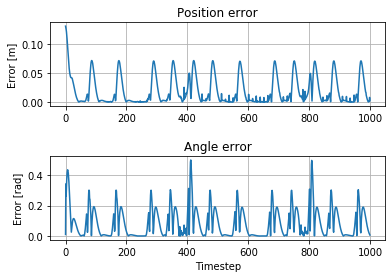

In [10]:
# Make plots
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(distance_error)
ax1.set(ylabel = 'Error [m]', title = 'Position error')
ax1.grid(axis = 'both')
ax2.plot(angle_error)
ax2.set(ylabel = 'Error [rad]', xlabel = 'Timestep', title = 'Angle error')
ax2.grid(axis = 'both')

fig.subplots_adjust(hspace = 0.6)

plt.savefig('command_pose_error.png', dpi = 300)



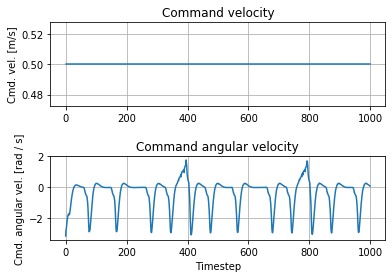

In [11]:
# Make plots
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(cmd_lin)
ax1.set(ylabel = 'Cmd. vel. [m/s]', title = 'Command velocity')
ax1.grid(axis = 'both')
ax2.plot(cmd_angle)
ax2.set(ylabel = 'Cmd. angular vel. [rad / s]', xlabel = 'Timestep', title = 'Command angular velocity')
ax2.grid(axis = 'both')

fig.subplots_adjust(hspace = 0.6)

plt.savefig('command_control_effort.png', dpi = 300)



To see qualitatively how you are doing:

In [ ]:
print("Your score: {}".format(total_reward))
view_results_ipython(local_env)

For this portion of the exercise, submit one plot with **cross-track error**, **angle error**, **commanded linear velocity** and **commanded angular velocity** vs. time. Lastly, experiment with the `lookup_distance` hyperparameter; does the lowering / raising this value match your hypothesis from earlier in this exercise?

Please submit the plot, `controller.py`, and `control.txt` inside of the zip file, and upload it to the Software submission link posted on Piazza.